Things to do
- Preprocess images
- Load images
- Set up data for training
- Set up feature learning
- Add classification
- Receive video feed
- Process video feed



In [250]:
import keras
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import cv2
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical


### Setting the path to the dataset

In [251]:

import pathlib

data_dir = pathlib.Path("../kaggle/")
train_path = f"{data_dir}/Train/"
test_path = f"{data_dir}/"
print(os.listdir(data_dir))

['predictionTest', 'Train.csv', 'Test', 'test', 'meta', 'TestWithDirs', 'train', 'Meta', 'Meta.csv', 'Test.csv', 'Train']


### Creating the dataset

##### About the dataset
We chose to split the test folder into 80% for testing and 20% for validation


In [252]:
#TODO: We should consider trying out different batch sizes
import tensorflow as tf

data = []
labels = []

batch_size = 30
img_height = 32
img_width = 32
img_size = (img_height, img_width)
epochs = 10

class_names = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }


# train_ds = tf.keras.utils.image_dataset_from_directory(
#     "./../kaggle/Train/",
#     validation_split=0.2,
#     subset="training",
#     seed=505,
#     image_size=img_size,
#     shuffle=True,
#     batch_size=batch_size
# )

# validation_ds = tf.keras.utils.image_dataset_from_directory(
#     "./../kaggle/Train/",
#     validation_split=0.2,
#     subset="validation",
#     seed=505,
#     shuffle=True,
#     image_size=img_size,
#     batch_size=batch_size
# )

# print(validation_ds)
#
# num_classes = len(train_ds.class_names)
# class_names = train_ds.class_names

num_categories = len(os.listdir(train_path))

def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(num_categories):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=img_size)
            image = img_to_array(img)
            images.append(image)
            labels.append(category)

    return images, labels



# import matplotlib.pyplot as plt
# For visualizing images in one batch
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(32):
#         ax = plt.subplot(15, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(train_ds.class_names[labels[i]])
#         plt.axis("off")
#


In [253]:
images, labels = load_data(train_path)

# One hot encoding the labels
labels = to_categorical(labels)

# Splitting the dataset into training and test set
x_train, x_val, y_train, y_val = train_test_split(np.array(images), labels, test_size=0.2)
print(len(x_train))
print(len(x_val))

validation_ds = (x_val, y_val)


31367
7842


### Setting up performance

In [254]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training the model

In [275]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",
                                   input_shape=(img_height,
                                                img_width,
                                                3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = tf.keras.Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# model = tf.keras.Sequential([
#     data_augmentation,
#     tf.keras.layers.Rescaling(1.0 / 255),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(rate=.3),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(rate=.5),
#     tf.keras.layers.Dense(num_categories, activation='softmax')
# ])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    #loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    # metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    metrics=['accuracy']
)

history = model.fit(
    x_train,
    y_train,
    validation_data=validation_ds,
    epochs=epochs,
    use_multiprocessing=True,
    workers=4
)

Epoch 1/10
981/981 [==============================] - 28s 28ms/step - loss: 1.7789 - accuracy: 0.5613 - val_loss: 0.3031 - val_accuracy: 0.9229

### Visualize the training

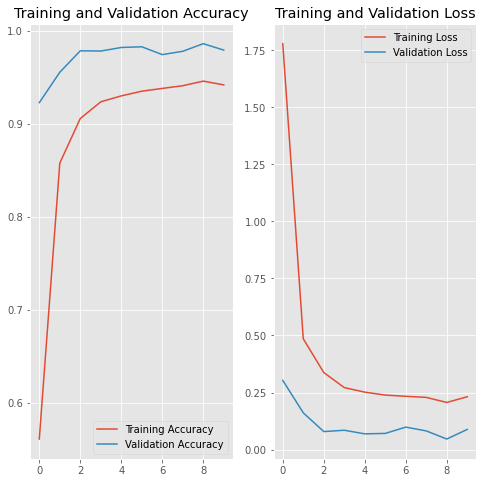

In [279]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing/Evaluating the model

In [280]:
#Predicting with the test data


test_ds = tf.keras.utils.image_dataset_from_directory(
    "../kaggle/TestWithDirs/",
    image_size=img_size,
    batch_size=batch_size,
)

res = model.evaluate(test_ds)
print("test loss, test acc:", res)

Found 12630 files belonging to 43 classes.


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1305, in test_step
        self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 43) are incompatible


#### Plotting the amount of different data

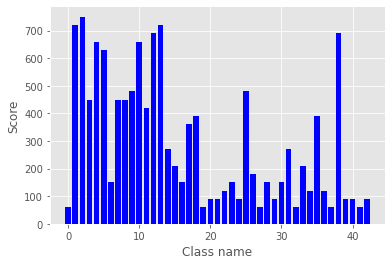

In [285]:
arr = []
for i in range(0, 43):
  _, _, files = next(os.walk(f"../kaggle/TestWithDirs/{i}/"))
  arr.append(len(files))

plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(class_names)]
plt.bar(x_pos, arr, color="blue")
plt.xlabel("Class name")
plt.ylabel("Score")
plt.show()

#### Predicting the trained model

['Speed limit (20km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No vehicles', 'Veh > 3.5 tons prohibited', 'No entry', 'Road narrows on the right', 'Pedestrians', 'Beware of ice/snow', 'Wild animals crossing', 'End no passing veh > 3.5 tons']
16


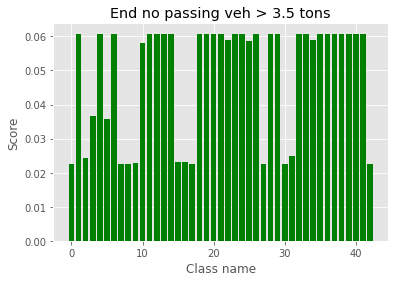

In [289]:
import os
from keras_preprocessing.image import load_img

wrong_guesses = []

for i in range(0, 43):
  img = tf.keras.preprocessing.image.load_img(f"../kaggle/meta/{i}.png", target_size=img_size)
  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  input_arr = np.expand_dims(input_arr, axis=0)
  #input_arr = np.array([input_arr])  # Convert single image to a batch.

  predict = model.predict(input_arr)
  score = tf.nn.softmax(predict[0])

  plt.style.use('ggplot')
  x_pos = [i for i, _ in enumerate(class_names)]
  plt.bar(x_pos, score, color="green")
  plt.xlabel("Class name")
  plt.ylabel("Score")
  plt.title(f"{class_names[i]}")
  #plt.show()

  if(i != np.argmax(score)):
    wrong_guesses.append(class_names[i])

  # print(
  #      "This image most likely belongs to {} with a {:.2f} percent confidence."
  #         .format(class_names[np.argmax(score)], 100 * np.max(score))
  # )
  # print(sum(score))

print(wrong_guesses)
print(len(wrong_guesses))

In [278]:
from sklearn.metrics import accuracy_score
import pandas as pd

y_test = pd.read_csv("../kaggle/" + 'Test.csv')
test_labels = y_test["ClassId"].values
test_images = y_test["Path"].values

test_labels = np.array(test_labels).astype(np.float)

output = list()
for img in test_images:
    image = load_img(os.path.join("../kaggle/", img), target_size=img_size)
    output.append(np.array(image))

x_test = np.array(output)
prediction = model.predict(x_test, verbose=1)

# Convert tests labels in single-digits instead of one-hot encoding
Y_pred = np.argmax(prediction,axis=1)


#Accuracy with the test data
print('Test data accuracy: ', accuracy_score(test_labels, Y_pred) * 100)

395/395 [==============================] - 4s 9ms/step